# Text Analytics - Assignment 3

Grammatikopoulou Maria - f3352310

Phevos A. Margonis - f3352317

Moniaki Melina - f3352321

#### Exercise 2

In [1]:
'''
TODO:
    o Na elenxw posa text einai >32 kai na ta splitarw se sub-sentences (Stin arxi tous na exoun kai ligo apo to prohgoumeno)
    x Fix evaluation metrics
    x Residuals, Layer-normalization
    x Baselines

'''

'\nTODO:\n    o Na elenxw posa text einai >32 kai na ta splitarw se sub-sentences (Stin arxi tous na exoun kai ligo apo to prohgoumeno)\n    x Fix evaluation metrics\n    x Residuals, Layer-normalization\n    x Baselines\n\n'

In [2]:
# NLP Parsing and Processing - Uncomment if using these libraries
# !pip install conllu
# !pip install halo
# !pip install pydot
import datetime
import os
import re
import time
import warnings
from collections import Counter

# import gensim.downloader as api
import fasttext
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from catalogue import create
from conllu import parse_incr
from halo import Halo
from keras.utils import to_categorical
from numpy.random import default_rng
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             f1_score, precision_recall_curve, precision_score,
                             recall_score)
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        TensorBoard)
from tensorflow.keras.layers import (LSTM, GRU, Add, Bidirectional, Dense, Dropout,
                                     Embedding, Input, Lambda,
                                     LayerNormalization, TextVectorization,
                                     TimeDistributed)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

rng = default_rng(587)


2024-02-28 22:15:51.459303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 22:15:51.459348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 22:15:51.464437: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 22:15:52.789305: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Parse the CONLLU files

In [3]:

# from sklearn.metrics.classification import _DEFAULT_ZERO_DIVISION
# # Set the default value for zero_division globally
# _DEFAULT_ZERO_DIVISION = 0

# # %% Parsing
# # ======= UNCOMMENT TO READ RAW CONLLU FILES =========================================
# # %% Parse conllu files
# def read_conllu(data_file_path: str) -> list[list[str], list[str]]:
#     """ Input path to file.
#         Return for each text its [tokens, upos]

#         Ta dataset exoun kapoia discrepancies vasi tou splitting convention pou akolouthoun.
#         Den iparxeei POS Tag '_' ara afairoume oles tis grammes pou exoun tetoio 'target'
#     """

#     docs = []
#     # Open the file and parse it
#     with open(data_file_path, 'r', encoding='utf-8') as file:
#         for tokenlist in tqdm(parse_incr(file), desc="Parsing", unit=" tokenlists"):
#             text, pos = [], []
#             for i in range(len(tokenlist)):
#                 token = tokenlist[i]
#                 if token['upos'] != '_':  # Important data cleaning trick
#                     text.append(token['form'])
#                     pos.append(token['upos'])

#             docs.append([text, pos])
#     return docs


# # Read data files
# train_data_raw = read_conllu('UD_English-GUM-master/en_gum-ud-train.conllu')
# val_data_raw = read_conllu('UD_English-GUM-master/en_gum-ud-dev.conllu')
# test_data_raw = read_conllu('UD_English-GUM-master/en_gum-ud-test.conllu')

# # %% Post-process raw-data
# def create_input_output_data(raw_data: list[list, list]) -> pd.DataFrame:
#     '''
#     Post process the raw data as X and y, to pass to Tensorflow.

#     Parameters
#     ----------
#     raw_data : list[list, list]
#         A list where each row has 2 lists.
#         List[0] are the sentences.
#         List[1] are the upos tags.

#     Returns
#     -------
#     df : pd.Dataframe{string,string}
#         Dataframe with columns X, y.

#     '''
#     X = [" ".join(tokenlist[0]) for tokenlist in raw_data]
#     y = [" ".join(tokenlist[1]) for tokenlist in raw_data]
#     df = pd.DataFrame({
#         'text': X,
#         'labels': y
#     })
#     return df


# # Convertion
# trainDF = create_input_output_data(train_data_raw)
# valDF = create_input_output_data(val_data_raw)
# testDF = create_input_output_data(test_data_raw)

# # %% Store processed data
# trainDF.to_csv('en_gum_train.csv', index=False)
# valDF.to_csv('en_gum_val.csv', index=False)
# testDF.to_csv('en_gum_test.csv', index=False)

## Data Exploration

In [4]:
trainDF = pd.read_csv('en_gum_train.csv').drop_duplicates().reset_index(drop=True)
valDF = pd.read_csv('en_gum_val.csv')
testDF = pd.read_csv('en_gum_test.csv')

In [5]:
trainDF.info()

trainDF.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8165 entries, 0 to 8164
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8165 non-null   object
 1   labels  8165 non-null   object
dtypes: object(2)
memory usage: 127.7+ KB


,text,labels
count,8165,8165
unique,8160,7331
top,Sure .,INTJ PUNCT
freq,3,61


In [6]:
trainDF.head()

,text,labels
0,Aesthetic Appreciation and Spanish Art :,ADJ NOUN CCONJ ADJ NOUN PUNCT
1,Insights from Eye - Tracking,NOUN ADP NOUN PUNCT NOUN
2,Claire Bailey - Ross claire.bailey-ross@port.a...,PROPN PROPN PUNCT PROPN PROPN PROPN ADP PROPN ...
3,Andrew Beresford a.m.beresford@durham.ac.uk Du...,PROPN PROPN PROPN PROPN PROPN PUNCT VERB PROPN
4,Daniel Smith daniel.smith2@durham.ac.uk Durham...,PROPN PROPN PROPN PROPN PROPN PUNCT VERB PROPN


In [7]:
print(pd.Series([len(text.split()) for text in trainDF.text]).describe())
percentile = 90
print(f"{percentile}th Percentile length of train sentences: {np.percentile([len(text.split()) for text in trainDF.text],percentile)}")

count    8165.000000
mean       18.003552
std        13.221574
min         1.000000
25%         8.000000
50%        15.000000
75%        25.000000
max       110.000000
dtype: float64
90th Percentile length of train sentences: 35.0


In [8]:
print(trainDF.text[0])
print(trainDF.labels[0])

Aesthetic Appreciation and Spanish Art :
ADJ NOUN CCONJ ADJ NOUN PUNCT


In [9]:
TARGET_NAMES = sorted(list(set(' '.join(trainDF.labels).split())))
NCLASSES = len(TARGET_NAMES)
print('Target Names:',TARGET_NAMES)

Target Names: ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']


## Majority Classifier

In [10]:

def flatten_and_encode(df) -> pd.DataFrame:
    '''Flatten each text sentence and each label. Then Encode the labels as category ints'''
    df_flattened        = df['text'].str.lower().str.split(expand=True).stack().reset_index(drop=True).to_frame(name='word') # Flatten train data
    df_flattened['tag'] = df['labels'].str.lower().str.split(expand=True).stack().reset_index(drop=True)
    df_flattened['tag'] = df_flattened['tag'].astype('category').cat.codes # Encode 'tag'
    return df_flattened

# Majority Dummy classifier: Find the most common label for each unique word using the Train-set
train_flattened  = flatten_and_encode(trainDF)
trainMajorityTag = train_flattened.groupby('word')['tag'].agg(lambda x: x.mode()[0]).to_frame() # Find the most common tag for each word
trainMajorityTag = trainMajorityTag.tag.to_dict() # dict{word: most_commont_tag}

# Flatten evaluation datasets
val_flattened  = flatten_and_encode(valDF)
test_flattened = flatten_and_encode(testDF)

# Get y_true for each dataset
y_train_true = train_flattened.tag.tolist()
y_val_true   = val_flattened.tag.tolist()
y_test_true  = test_flattened.tag.tolist()

# Find the overall most common tag inside train-set
most_common_tag = train_flattened.tag.mode()[0]

# Create the prediction using Majority dummy classifier
y_train_pred = [trainMajorityTag.get(word,most_common_tag) for word in train_flattened.word]
y_val_pred   = [trainMajorityTag.get(word,most_common_tag) for word in val_flattened.word]
y_test_pred  = [trainMajorityTag.get(word,most_common_tag) for word in test_flattened.word]

majority_val_acc = accuracy_score(y_val_true, y_val_pred).round(2)

print(classification_report(y_train_true, y_train_pred, target_names=TARGET_NAMES))
print(classification_report(y_val_true, y_val_pred, target_names=TARGET_NAMES))
print(classification_report(y_test_true, y_test_pred, target_names=TARGET_NAMES))

              precision    recall  f1-score   support

         ADJ       0.91      0.93      0.92      9761
         ADP       0.90      0.89      0.90     14045
         ADV       0.89      0.85      0.87      6969
         AUX       0.87      0.95      0.91      7689
       CCONJ       0.99      1.00      0.99      4846
         DET       0.95      0.98      0.96     12066
        INTJ       0.73      0.76      0.74      1144
        NOUN       0.92      0.95      0.93     24618
         NUM       0.95      1.00      0.98      2924
        PART       0.69      0.90      0.78      3466
        PRON       0.92      0.96      0.94     12059
       PROPN       0.94      0.82      0.88      8934
       PUNCT       0.99      1.00      1.00     20274
       SCONJ       0.85      0.33      0.48      2324
         SYM       0.95      0.68      0.79       231
        VERB       0.93      0.89      0.91     15347
           X       0.97      0.73      0.84       302

    accuracy              

## Prepare X, y

In [11]:
MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH = 32
EMBEDDING_DIM = 300

vectorize_Y = TextVectorization(max_tokens=MAX_WORDS,
                                output_mode='int',
                                standardize=None,
                                ngrams=1,
                                vocabulary=TARGET_NAMES,
                                output_sequence_length=MAX_SEQUENCE_LENGTH)

y_train_sequential = vectorize_Y(trainDF.labels.values).numpy()
y_val_sequential = vectorize_Y(valDF.labels.values).numpy()
y_test_sequential = vectorize_Y(testDF.labels.values).numpy()

TARGET_NAMES = vectorize_Y.get_vocabulary()

2024-02-28 22:15:57.342580: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-28 22:15:57.537191: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-28 22:15:57.537415: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
print(f"{' New Target Names ':=^80}")
print(vectorize_Y.get_vocabulary(), '\n')
print('-First sentence target names:',trainDF.labels[0])
print('-First sentence targets encoded:',y_train_sequential[0])
print(f"{' An other sample ':=^80}")
print(valDF.labels[1])
print(y_val_sequential[1])

=============================== New Target Names ===============================
['', '[UNK]', 'ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X'] 

-First sentence target names: ADJ NOUN CCONJ ADJ NOUN PUNCT
-First sentence targets encoded: [ 2  9  6  2  9 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
=============================== An other sample ================================
NOUN ADP NOUN PUNCT VERB ADJ NOUN PUNCT NOUN PUNCT AUX VERB ADJ NOUN ADP DET ADJ NOUN VERB DET NOUN CCONJ NOUN ADP NOUN NOUN PUNCT NUM PUNCT SYM PUNCT NUM PUNCT PUNCT
[ 9  3  9 14 17  2  9 14  9 14  5 17  2  9  3  7  2  9 17  7  9  6  9  3
  9  9 14 10 14 16 14 10]


In [13]:
vectorizer = TextVectorization(max_tokens=MAX_WORDS,
                               output_mode='int',
                               standardize="lower",
                               ngrams=1,
                               output_sequence_length=MAX_SEQUENCE_LENGTH)

vectorizer.adapt(trainDF.text)

MAX_WORDS = vectorizer.vocabulary_size()
print(f"Vocabulary size: { MAX_WORDS } words.")

Vocabulary size: 14388 words.


In [14]:
# Gold
print(f"{' Sentences ':=^80}")
print(trainDF.text[0:2])
# Vectorized
print(f"{' Vectorized Representations ':=^80}")
print(vectorizer.call(trainDF.text[0:2]))
# Reconstruction
sentences = vectorizer.call(trainDF.text[0:2])
vocabulary = vectorizer.get_vocabulary()
words = [vocabulary[idx] for sentence in sentences for idx in sentence]
print(f"{' Reconstructed from vectorizer ':=^80}")
print(words)

================================== Sentences ===================================
0    Aesthetic Appreciation and Spanish Art :
1                Insights from Eye - Tracking
Name: text, dtype: object
========================== Vectorized Representations ==========================
tf.Tensor(
[[1343 2367    5  629  286   60    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [3023   30  992   20 1502    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]], shape=(2, 32), dtype=int64)
======================== Reconstructed from vectorizer =========================
['aesthetic', 'appreciation', 'and', 'spanish', 'art', ':', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'insights', 'from', 'eye', '-', 'tracking', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

## Embedding Matrix

In [15]:
print('Loading Fasttext model...')
fasttext_model = fasttext.load_model('cc.en.300.bin')
print("Process completed!")

embedding_matrix = np.zeros(shape=(MAX_WORDS, 300))

for w2idx, _word in tqdm(enumerate(vectorizer.get_vocabulary()), total=MAX_WORDS, desc='Embedding matrix creation'):
    # Skip PAD and UNK tokens
    if w2idx >= 2:
        embedding_matrix[w2idx] = fasttext_model.get_word_vector(_word)

del fasttext_model

Loading Fasttext model...


Process completed!


Embedding matrix creation: 100%|██████████| 14388/14388 [00:00<00:00, 62998.83it/s]


## Recurrent Neural Network

In [16]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        val_targ = tf.cast(val_targ, dtype=tf.float32)
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)

        _val_f1 = f1_score(val_targ, val_predict, average="weighted", zero_division=1)
        _val_recall = recall_score(val_targ, val_predict, average="weighted", zero_division=1)
        _val_precision = precision_score(val_targ, val_predict, average="weighted", zero_division=1)

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return


### CUDA GPU CELLS
The criteria for a GRU (or LSTM) layer to use cuDNN kernels include:

- Activation Function: The activation must be tanh for the recurrent activation.
- Recurrent Dropout: When using recurrent dropout (recurrent_dropout > 0), the layer cannot use cuDNN kernels because cuDNN does not support recurrent dropout natively.
- Unrolling the RNN: If the RNN layer is unrolled (unroll=True), it might not be compatible with cuDNN.
- Using Masking: Sometimes, using sequence masking can also prevent the use of cuDNN, depending on how the masking is applied and the specific TensorFlow version.

In our case, the use of recurrent_dropout is the reason TensorFlow cannot use cuDNN kernels. cuDNN does not support recurrent dropout directly, leading TensorFlow to fall back to a more generic, and usually slower, GPU kernel implementation.

### Embedding Layer
The Embedding layer receives a Tensor of shape (batch size, fixed sequence length) and is responsible for converting it into a 3D Tensor (batch size, fixed sequence length, embedding). At this point, the designer must make a crucial decision regarding the padded sequences. Typically, padded sequences should be masked with `mask_zero=True` so that the model can ignore them during training. During training and evaluation (`model.evaluate()`), the model can correctly identify the padded tokens and ignore them. However, the problem arises during inference (`model.predict()`), as the model cannot properly identify and thus mask these tokens. At this stage, the model attempts to infer the class of the padded tokens without prior knowledge of their existence, resulting in the model assigning a fixed class, in this case, class '4', to all 'pad' tokens. This issue complicates the final evaluation of the model (classification reports and AUC scores) because it prevents an objective comparison between the actual and predicted classes. A different problem formulation or architecture might overcome this problem while still retaining the mask.

Alternatively, setting `mask_zero` to False forces the model to consider the padding during its training phase, represented by zeros, to extract their proper embeddings from the embedding matrix, treat the zeros as a viable class, and thus learn to predict them. This approach is problematic for two reasons. Firstly, it will include the overrepresented class zero in the model's metrics report, inflating the metrics and providing a non-objective view of the model's performance. Secondly, the model may misclassify other classes as class zero, deflating the precision-recall metrics for other classes.

To address this discrepancy, manual masking must be implemented in both scenarios to remove the padded tokens from the evaluation process. The following approach creates the mask from the encoded target classes. In a production setting, this decision is biased because target labels are not available, necessitating derivation from the encoded text sequences (which would require a different architecture, possibly excluding the vectorization layer inside the model).

Ultimately, `mask_zero=True` is chosen as it offers the most objective approach despite the need for manual masking.

In [28]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

LSTM_SIZE = 300  # h diastasi tou h
DENSE = 128

# # TENSORBOARD: Create a log directory with a timestamp to create a unique directory for each run
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=0)

# Functional API
text = Input(shape=(1,), dtype=tf.string, name="input_text")
vectorized = vectorizer(text)
word_embeddings = Embedding(MAX_WORDS, EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            mask_zero=True, # Change to False for production. Because of TimeDistributed
                            trainable=False)(vectorized)
word_embeddings = Dropout(0.33)(word_embeddings)
# RNN
rnn_states_l1 = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, recurrent_dropout=0.0))(word_embeddings)
rnn_states_l2 = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, recurrent_dropout=0.0))(rnn_states_l1)
rnn_residuals_1 = LayerNormalization()(Add()([rnn_states_l1, rnn_states_l2]))
rnn_states_l3 = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, recurrent_dropout=0.0))(rnn_residuals_1)
rnn_residuals_2 = LayerNormalization()(Add()([rnn_residuals_1, rnn_states_l3]))
rnn_states_l4 = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, recurrent_dropout=0.0))(rnn_residuals_2)
rnn_residuals_3 = LayerNormalization()(Add()([rnn_residuals_2, rnn_states_l4]))

# MLP
# TimeDistributed is not needed, as it is implemented automaticaly on the backend-side of the Dense layer.
rich_features = TimeDistributed(Dense(units=DENSE, activation='relu'))(rnn_residuals_3)
rich_features = Dropout(0.4)(rich_features)
rich_features = TimeDistributed(Dense(units=DENSE, activation='tanh'))(rich_features)
rich_features = Dropout(0.1)(rich_features)
# Classification
pos_tags = TimeDistributed(Dense(NCLASSES+2, activation='softmax', name="output"))(rich_features) # +2 due to vectorizer_Y
# Instantiate
model = tf.keras.Model(inputs=text, outputs=pos_tags)

print(model.summary())

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')
# Callback to save the Keras model or model weights at some frequency.
checkpoint = ModelCheckpoint(
    'checkpoints/model_ex2_masked',
    monitor='val_loss',  # Save the model that scores the best @ validation accuracy
    mode='min',  # Since accuracy -> maximization
    verbose=2,
    save_best_only=True,
    save_weights_only=False,
    save_format='tf'  # Use TensorFlow format for saving (due to TextVectorization layer not supporting HDF5)
)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

start_training_time = time.time()

history = model.fit(
    np.array(trainDF.text),
    y_train_sequential,
    validation_data=(np.array(valDF.text), y_val_sequential),
    batch_size=256,
    epochs=50,
    shuffle=True,
    callbacks=[early_stopping]) #, tensorboard_callback])

end_training_time = time.time()

print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} \n')

# Same the complete model once
model.save('checkpoints/model_ex2_masked')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_text (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 32)                   0         ['input_text[0][0]']          
 Vectorization)                                                                                   
                                                                                                  
 embedding_1 (Embedding)     (None, 32, 300)              4316400   ['text_vectorization_1[1][0]']
                                                                                                  
 dropout_3 (Dropout)         (None, 32, 300)              0         ['embedding_1[0][0]']   

INFO:tensorflow:Assets written to: checkpoints/model_ex2_masked/assets


In [29]:
loss, accuracy = model.evaluate(np.array(trainDF.text), y_train_sequential, verbose=1)
print(f"Loss: {loss:.4f}\nAccuracy: {accuracy*100:.4f}%")

256/256 [==============================] - 5s 19ms/step - loss: 0.0551 - accuracy: 0.9817
Loss: 0.0551
Accuracy: 98.1716%


In [30]:
loss, accuracy = model.evaluate(np.array(valDF.text), y_val_sequential, verbose=1)
print(f"Loss: {loss:.4f}\nAccuracy: {accuracy*100:.4f}%") # GRU .9366

35/35 [==============================] - 1s 20ms/step - loss: 0.2038 - accuracy: 0.9369
Loss: 0.2038
Accuracy: 93.6906%


In [31]:
loss, accuracy = model.evaluate(np.array(testDF.text), y_test_sequential, verbose=1)
print(f"Loss: {loss:.4f}\nAccuracy: {accuracy*100:.4f}%")

35/35 [==============================] - 1s 19ms/step - loss: 0.2565 - accuracy: 0.9209
Loss: 0.2565
Accuracy: 92.0876%


In [ ]:
model = load_model('checkpoints/model_ex2_masked') # or model_ex2_masked_masked

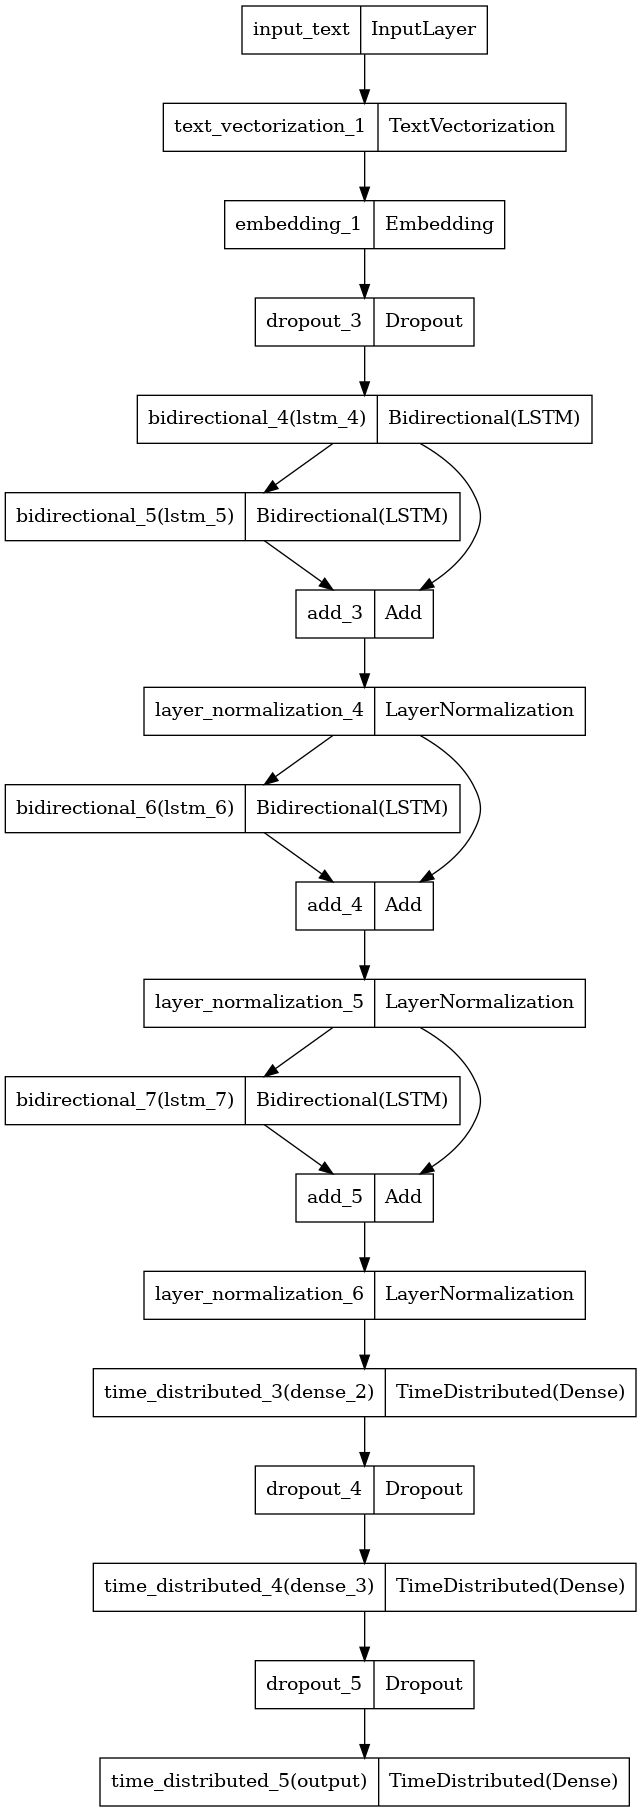

In [18]:
tf.keras.utils.plot_model(model,"POS_tagging_model.png")

In [ ]:
# !tensorboard --logdir=logs/fit
# '''
# http://localhost:6006/
# '''

In [20]:
mask_train = (y_train_sequential.flatten() != 0)
predictions = np.argmax(model.predict(trainDF.text), -1)
print(classification_report(y_train_sequential.flatten()[mask_train],  # (sentence, labels) -> (all_labels)
                            predictions.flatten()[mask_train],
                            labels=list(range(2,19)),
                            target_names=TARGET_NAMES[2:]
                            ))

mask_val = (y_val_sequential.flatten() != 0)
predictions = np.argmax(model.predict(valDF.text), -1)
print(classification_report(y_val_sequential.flatten()[mask_val], 
                            predictions.flatten()[mask_val],
                            labels=list(range(2,19)),
                            target_names=TARGET_NAMES[2:]
                            ))

validation_accuracy = accuracy_score(
    y_val_sequential.flatten()[y_val_sequential.flatten() != 0],
    predictions.flatten()[y_val_sequential.flatten() != 0]
)

mask_test = (y_test_sequential.flatten() != 0)
predictions = np.argmax(model.predict(testDF.text), -1)
print(classification_report(y_test_sequential.flatten()[mask_test], 
                            predictions.flatten()[mask_test],
                            labels=list(range(2,19)),
                            target_names=TARGET_NAMES[2:]
                            ))

print(validation_accuracy)

256/256 [==============================] - 5s 18ms/step
              precision    recall  f1-score   support

         ADJ       0.95      0.97      0.96      8907
         ADP       0.98      0.99      0.99     12922
         ADV       0.98      0.94      0.96      6508
         AUX       0.99      1.00      1.00      7266
       CCONJ       1.00      1.00      1.00      4356
         DET       1.00      1.00      1.00     11187
        INTJ       0.96      0.94      0.95      1118
        NOUN       0.97      0.97      0.97     22484
         NUM       0.99      0.99      0.99      2567
        PART       1.00      0.99      0.99      3253
        PRON       1.00      1.00      1.00     11447
       PROPN       0.93      0.94      0.94      8116
       PUNCT       1.00      1.00      1.00     17766
       SCONJ       0.96      0.93      0.95      2183
         SYM       0.96      0.98      0.97       211
        VERB       0.99      0.98      0.99     14428
           X       0.97  

In [21]:
# Predict class probabilities to be used for PR-AUC
def my_padded_multiclass_auc_report( y_true, y_pred, title: str, TARGET_NAMES=TARGET_NAMES) -> None:
    """
    Calculate the Precision-Recall AUC for each class, and then their Macro-averaged score.
    The classes are padded with '', and [UNK] classes because they have beed created with 
    TextVectorizer() layer.

    Parameters
    ----------
    y_true : np.array of int
        The one-hot label vectors for each data-point.
    y_pred : np.array of float
        The MxN predicted probabilities for each data-point (M) and class (N).
    title : str
        The title of the data-set that is processed. E.g.: Train/Val/Test.

    Returns
    -------
    None

    """
    print(f"=== PR-AUC for {title} ===")
    macro_auc = []
    for i in range(2,len(TARGET_NAMES)):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        area = auc(recall, precision)
        print(f"PR-AUC for class {TARGET_NAMES[i]}: {area*100:.2f}%")
        macro_auc.append(area)

    print(f"-> Macro-averaged PR-AUC: {np.mean(macro_auc)*100:.2f}%\n")

In [22]:
# Suppress specific warnings temporarily
warnings.filterwarnings("ignore", message="No positive class found in y_true")

# Predict probas.
# Reshape 3D to 2D (samples, max_sequence, classes) -> (tokens,classes). Then apply mask.
predictions_train = model.predict(trainDF.text)
predictions_train = predictions_train.reshape(-1, predictions_train.shape[-1])[mask_train]
predictions_val   = model.predict(valDF.text)
predictions_val   = predictions_val.reshape(-1, predictions_val.shape[-1])[mask_val]
predictions_test  = model.predict(testDF.text)
predictions_test  = predictions_test.reshape(-1, predictions_test.shape[-1])[mask_test]

# PR-AUC report
my_padded_multiclass_auc_report(to_categorical(y_train_sequential.flatten()[mask_train]), predictions_train, 'Train')
my_padded_multiclass_auc_report(to_categorical(y_val_sequential.flatten()[mask_val]), predictions_val, 'Validation')
my_padded_multiclass_auc_report(to_categorical(y_test_sequential.flatten()[mask_test]), predictions_test, 'Test')

35/35 [==============================] - 1s 17ms/step
=== PR-AUC for Train ===
PR-AUC for class ADJ: 99.18%
PR-AUC for class ADP: 99.88%
PR-AUC for class ADV: 99.39%
PR-AUC for class AUX: 99.98%
PR-AUC for class CCONJ: 99.98%
PR-AUC for class DET: 99.97%
PR-AUC for class INTJ: 98.83%
PR-AUC for class NOUN: 99.60%
PR-AUC for class NUM: 99.88%
PR-AUC for class PART: 99.93%
PR-AUC for class PRON: 99.99%
PR-AUC for class PROPN: 98.38%
PR-AUC for class PUNCT: 100.00%
PR-AUC for class SCONJ: 98.51%
PR-AUC for class SYM: 99.34%
PR-AUC for class VERB: 99.86%
PR-AUC for class X: 91.17%
-> Macro-averaged PR-AUC: 99.05%

=== PR-AUC for Validation ===
PR-AUC for class ADJ: 94.74%
PR-AUC for class ADP: 99.25%
PR-AUC for class ADV: 95.12%
PR-AUC for class AUX: 99.84%
PR-AUC for class CCONJ: 99.96%
PR-AUC for class DET: 99.97%
PR-AUC for class INTJ: 94.46%
PR-AUC for class NOUN: 97.28%
PR-AUC for class NUM: 92.67%
PR-AUC for class PART: 99.14%
PR-AUC for class PRON: 99.84%
PR-AUC for class PROPN: 81.

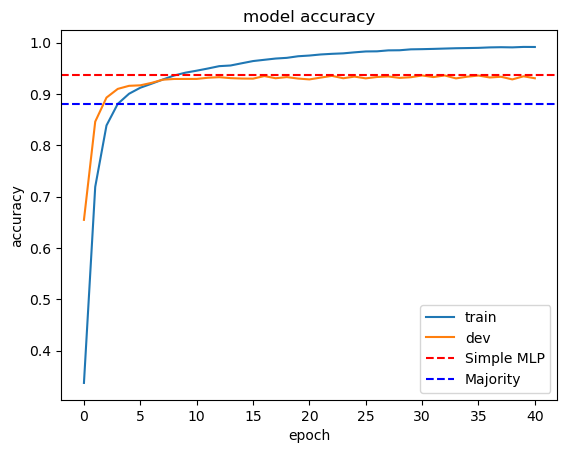

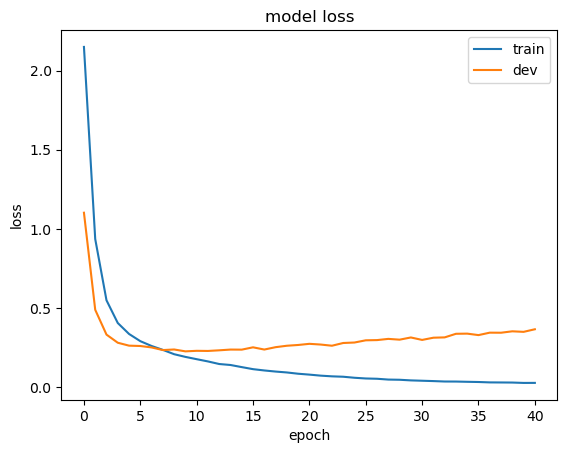

In [57]:
# history: Returned by the fit. Keeps the metrics for each epoch
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.axhline(y=0.9365, color='red', linestyle='--', label='Simple MLP')
plt.axhline(y=majority_val_acc, color='blue', linestyle='--', label='Majority')
plt.legend(['train', 'dev', 'Simple MLP', 'Majority'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()